# Benchmark example of Rn220 fitting

In [1]:
import os
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

import appletree as apt
from appletree.utils import get_file_path

Using Normal as an approximation of Binomial
Using aptext package from https://github.com/XENONnT/applefiles


In [2]:
# set GPU memory limit
apt.set_gpu_memory_usage(0.2)

In [3]:
# Load configuration file
# You should change the configuration file for XENONnT
config = get_file_path('rn220.json')

# Initialize context
tree = apt.Context(config)

In [4]:
tree.print_context_summary(short=True)


LIKELIHOOD rn220_llh

----------------------------------------
BINNING

    bins_type: equiprob
    bins_on: ['cs1', 'cs2']

----------------------------------------
DATA

    file_name: data_Rn220.csv
    data_rate: 2000.0

----------------------------------------
MODEL

    COMPONENT 0: rn220_er
        type: simulation
        rate_par: rn220_er_rate
        pars: {'s2_threshold', 'rf0', 'fano', 'rn220_er_rate', 'py3', 'py2', 's1_eff_3f_sigma', 'p_dpe', 'drift_velocity', 'g1', 's1_cut_acc_sigma', 'py4', 'py1', 'elife_sigma', 'rf1', 'gas_gain', 'py0', 's2_cut_acc_sigma', 'w', 'nex_ni_ratio', 'field', 'g2'}

    COMPONENT 1: rn220_ac
        type: fixed
        file_name: AC_Rn220.pkl
        rate_par: rn220_ac_rate
        pars: {'rn220_ac_rate'}

----------------------------------------



In [5]:
result = tree.fitting(nwalkers=200, iteration=100)

With no backend


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:34<00:00,  1.55s/it]


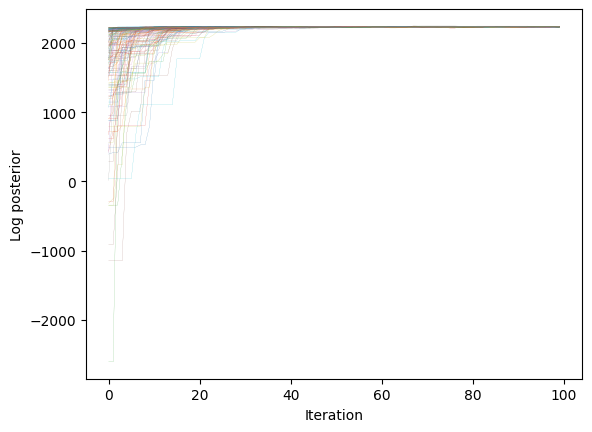

In [6]:
logp = tree.sampler.get_log_prob()

for _logp in logp.T:
    plt.plot(_logp, lw=0.1)

plt.xlabel('Iteration')
plt.ylabel('Log posterior')
plt.show()

In [7]:
logp = tree.sampler.get_log_prob(flat=True)
chain = tree.sampler.get_chain(flat=True)
mpe_parameters = chain[np.argmax(logp)]

par_manager = tree.par_manager
par_manager.set_parameter(par_manager.parameter_fit, mpe_parameters)
parameters = par_manager.get_all_parameter()

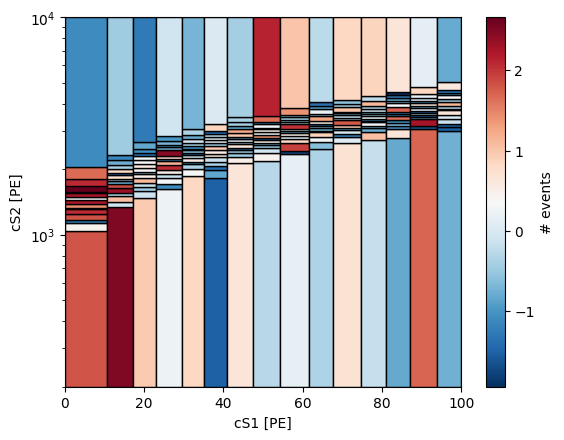

In [8]:
key = apt.randgen.get_key()
key, model_hist = tree.likelihoods['rn220_llh'].components['rn220_er'].simulate_hist(key, int(1e6), parameters)
model_hist += tree.likelihoods['rn220_llh'].components['rn220_ac'].simulate_hist(parameters)
data_hist = tree.likelihoods['rn220_llh'].data_hist

bins = tree.likelihoods['rn220_llh'].components['rn220_er'].bins

apt.plot_irreg_histogram_2d(*bins, (model_hist-data_hist)/jnp.sqrt(data_hist))
plt.yscale('log')
plt.xlabel('cS1 [PE]')
plt.ylabel('cS2 [PE]')
plt.show()

In [9]:
from scipy.stats import chi2
t = jnp.sum(((model_hist-data_hist)/jnp.sqrt(data_hist))**2)
p = 1 - chi2.cdf(t, 30*30)
print(f'p = {p}')

p = 1.0


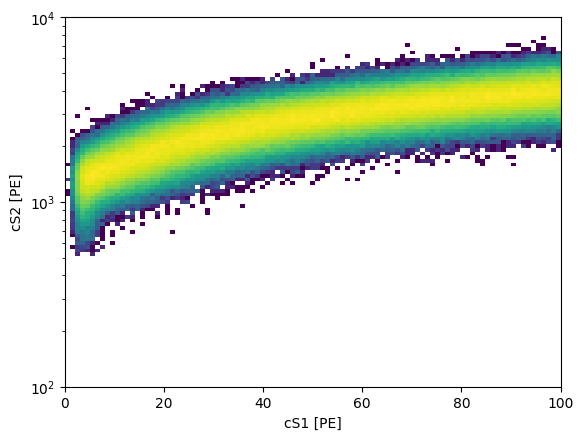

In [10]:
from matplotlib.colors import LogNorm

key = apt.randgen.get_key()
key, (cs1, cs2, eff) = tree.likelihoods['rn220_llh'].components['rn220_er'].simulate(key, int(1e6), parameters)

plt.hist2d(cs1, cs2, weights=eff, bins=[np.linspace(0, 100, 100), np.logspace(2, 4, 100)], norm=LogNorm())
plt.yscale('log')
plt.xlabel('cS1 [PE]')
plt.ylabel('cS2 [PE]')
plt.show()